# Train/Test the True Relationship Model

This notebook is design to predict DG relationships on the entity level. Here we are taking the input from the Bi-LSTM model, prior probability notebook and the summary statistics notebook and combinging it into a single dataset. From there we train a Ridge LR model and an elastic net LR model to make the final prediction.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import csv
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import tqdm

# Set up the Training and Testing Set

In [2]:
data = pd.read_table("data/disease_gene_association_features.tsv")
data.head(2)

,disease_id,gene_id,nlog10_p_value,co_odds_ratio,co_expected_sen_count,delta_lower_ci,hetnet_labels,marginals,split,logit_prior_perm
0,DOID:12849,3569,0.000207,0.617773,62.795531,-0.001252,1,0.340116,0,0.644292
1,DOID:1324,6647,-0.000000,0.142479,194.551269,-0.044854,-1,0.192470,0,-1.379122


In [3]:
data.split.value_counts()

0    66446
1    19615
Name: split, dtype: int64

In [4]:
non_features = [
    "disease_id", "gene_id",
    "hetnet_labels", "split"
]

X = data.query("split==0")[[col for col in data.columns if col not in non_features]]
Y = data.query("split==0")["hetnet_labels"]

X_dev = data.query("split==1")[[col for col in data.columns if col not in non_features]]
Y_dev = data.query("split==1")["hetnet_labels"]

In [5]:
print(Y.value_counts())
print()
print(Y_dev.value_counts())
print()

-1    59847
 1     6599
Name: hetnet_labels, dtype: int64

-1    17720
 1     1895
Name: hetnet_labels, dtype: int64



# Feature AUROCS

The code below generates area under ROCs (auroc) for each feature in the dataset. Looking below the NLP feature (marginals) is under performing compared to the co-occurence feature set.

(0.5, 1)

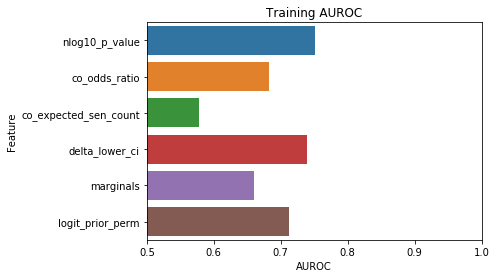

In [6]:
feature_rocs = []
for feature in X.columns:
    fpr, tpr, _ = roc_curve(Y, X[feature])
    feature_auc = auc(fpr, tpr)
    feature_rocs.append((feature, feature_auc))

feature_roc_df = pd.DataFrame(feature_rocs, columns=["Feature", "AUROC"])
ax = sns.barplot(x="AUROC", y="Feature", data=feature_roc_df)
plt.title("Training AUROC")
plt.xlim([0.5,1])

(0.5, 1)

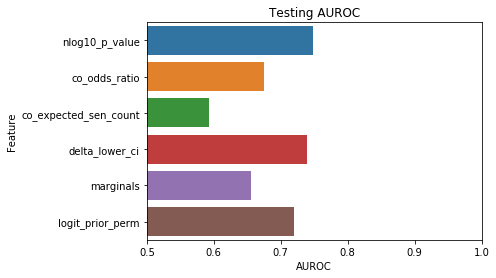

In [7]:
feature_rocs = []
for feature in X.columns:
    fpr, tpr, _ = roc_curve(Y_dev, X_dev[feature])
    feature_auc = auc(fpr, tpr)
    feature_rocs.append((feature, feature_auc))

feature_roc_df = pd.DataFrame(feature_rocs, columns=["Feature", "AUROC"])
ax = sns.barplot(x="AUROC", y="Feature", data=feature_roc_df)
plt.title("Testing AUROC")
plt.xlim([0.5,1])

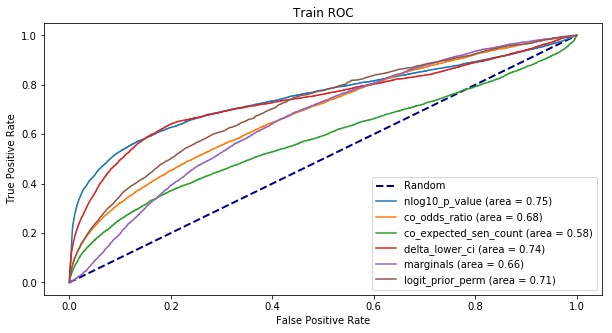

In [8]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

for feature in X.columns:
    # Plot the p_values log transformed
    fpr, tpr, thresholds= roc_curve(Y, X[feature])
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="{} (area = {:0.2f})".format(feature, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

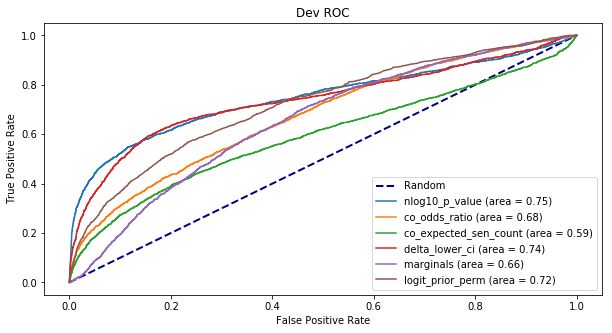

In [9]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

for feature in X.columns:
    # Plot the p_values log transformed
    fpr, tpr, thresholds= roc_curve(Y_dev, X_dev[feature])
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="{} (area = {:0.2f})".format(feature, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Dev ROC')
plt.legend(loc="lower right")

# Correlation Matrix

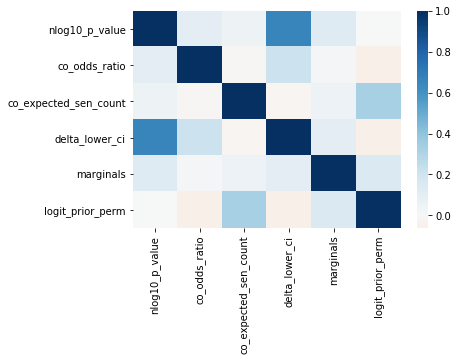

In [10]:
feature_corr_mat = X.corr()
sns.heatmap(feature_corr_mat, cmap="RdBu", center=0)

# Train the Machine Learning Algorithms

Here we use gridsearch to optimize both models using 10 fold cross validation. After exhausting the list of parameters, the best model is chosen and analyzed. 

In [11]:
n_iter = 100
final_models = []

data = [
    X.drop("marginals", axis='columns'),
    X
]

dev_data = [
    X_dev.drop("marginals", axis='columns'),
    X_dev
]

lr_grids = [
    {'C':np.linspace(1e-35, 1, num=10)}
    for i in data
]

lr_model = LogisticRegression()

In [12]:
%%time

for dataset, lr_grid in zip(data, lr_grids):
    # Train on data 
    final_model = GridSearchCV(lr_model, 
                               lr_grid, cv=10, n_jobs=3,
                               verbose=1, scoring='roc_auc', return_train_score=True)
    final_model.fit(dataset, Y)
    final_models.append(final_model)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    9.6s finished


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Done  94 tasks      | elapsed:    9.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    9.8s finished


CPU times: user 1.19 s, sys: 360 ms, total: 1.55 s
Wall time: 20.1 s


## Parameter Optimization

In [13]:
training_result = pd.DataFrame(final_models[0].cv_results_)

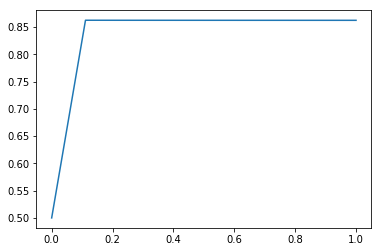

In [14]:
plt.plot(training_result['param_C'], training_result['mean_test_score'])

In [15]:
training_result = pd.DataFrame(final_models[1].cv_results_)

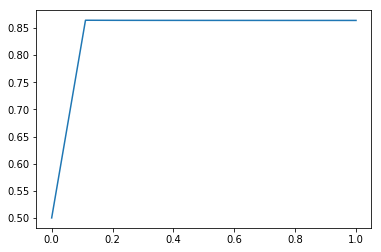

In [16]:
plt.plot(training_result['param_C'], training_result['mean_test_score'])

## LR Weights

In [17]:
# No Marginals
pd.DataFrame(
    list(
        zip(
            final_models[0].best_estimator_.coef_[0],
            [col for col in data[0].columns if col not in non_features]
        )
    )
    ,columns=["weight","feature"])

,weight,feature
0,0.105936,nlog10_p_value
1,0.001379,co_odds_ratio
2,0.000052,co_expected_sen_count
3,2.398418,delta_lower_ci
4,0.755470,logit_prior_perm


In [18]:
# With Marginals
pd.DataFrame(
    list(
        zip(
            final_models[1].best_estimator_.coef_[0],
            [col for col in data[1].columns if col not in non_features]
        )
    )
    ,columns=["weight","feature"])

,weight,feature
0,0.104241,nlog10_p_value
1,0.001298,co_odds_ratio
2,0.000051,co_expected_sen_count
3,2.318706,delta_lower_ci
4,1.800646,marginals
5,0.728700,logit_prior_perm


# ML Performance

Here we are plotting the two different models against each other. One doesn't have the NLP marginals while the other one does. Looking at the ROC and the PR plots there doesn't seem to be a different between both models. 

In [19]:
colors = ["green", "orange"]
labels = ["LR_no_marginals", "LR_marginals"]

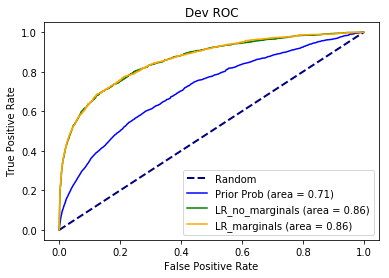

In [20]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

# Plot the p_values log transformed
fpr, tpr, thresholds= roc_curve(Y, X["logit_prior_perm"])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label="{} (area = {:0.2f})".format("Prior Prob", model_auc))

for dataset, model, color, label in zip(dev_data, final_models, colors, labels):
    fpr, tpr, thresholds= roc_curve(Y_dev, model.predict_proba(dataset)[:,1])
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label="{} (area = {:0.2f})".format(label, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Dev ROC')
plt.legend(loc="lower right")

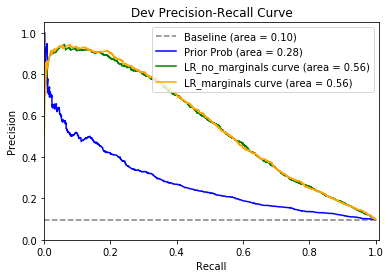

In [21]:
plt.figure()

#Plot baseline
positive, negative = Y_dev.value_counts()[1], Y_dev.value_counts()[-1]
baseline = positive/(positive+negative)
plt.plot([0,1], [baseline, baseline],
         color='grey', linestyle='--', label="{} (area = {:0.2f})".format("Baseline", baseline))

# Plot the p_values log transformed
precision, recall, _= precision_recall_curve(Y_dev, X_dev["logit_prior_perm"])
model_auc = auc(recall, precision)
plt.plot(recall, precision, color='blue', label="{} (area = {:0.2f})".format("Prior Prob", model_auc))

for dataset, model, color, label in zip(dev_data, final_models, colors, labels):
    precision, recall, _ = precision_recall_curve(Y_dev, model.predict_proba(dataset)[:,1])
    model_auc = auc(recall, precision)
    plt.plot(recall, precision, color=color, label="{} curve (area = {:0.2f})".format(label, model_auc))

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Dev Precision-Recall Curve')
plt.xlim([0, 1.01])
plt.ylim([0, 1.05])
plt.legend(loc="upper right")